# fastai Multi Core TPU Training Example (Multi Core) - CIFAR

## Installation and Setup

Downgrade from pytorch 1.8 (colab default) and install pytorch 1.7.1 because fastai (as of 2.2.7) doesn't support pytorch 1.8 as of yet.

In [ ]:
!pip install -qqq --no-cache-dir torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchtext==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 735.4MB 1.1MB/s 
     |████████████████████████████████| 12.8MB 2.5MB/s 
     |████████████████████████████████| 7.0MB 6.0MB/s 


Install latest fastai (2.2.7)

In [ ]:
!pip install -Uqq fastai --upgrade

     |████████████████████████████████| 194kB 6.3MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 


Setup colab directories to show downloaded fastai data and models

In [ ]:
!curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.


Install pytorch-xla 1.7

In [ ]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 31kB/s 
     |████████████████████████████████| 61kB 2.9MB/s 
ERROR: earthengine-api 0.1.254 has requirement google-api-python-client>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.


Install the fastai_xla_extensions package

In [ ]:
!pip install -Uqq fastai_xla_extensions
# !pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions.git

Check which versions of pytorch and fastai packages are installed.

In [ ]:
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.1+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.8.0
torchvision==0.8.2+cu101
fastai==2.2.7
fastai-xla-extensions==0.0.8
fastcore==1.3.19
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


## Start of code

Import fastai and fastai_xla_extension packages

In [ ]:
from fastai.vision.all import *
from fastai_xla_extensions.all import *

In [ ]:
path = untar_data(URLs.CIFAR)

In [ ]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(valid_name='test'),
    item_tfms=Resize(32),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
data.summary(path)

Setting-up type transforms pipelines
Found 60000 items
2 datasets of sizes 50000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/cifar10/train/horse/44353_horse.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/cifar10/train/horse/44353_horse.png
    applying parent_label gives
      horse
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(7)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(7))


Found 60000 items
2 datasets of sizes 50000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after

In [ ]:
dls = data.dataloaders(path, bs=64)

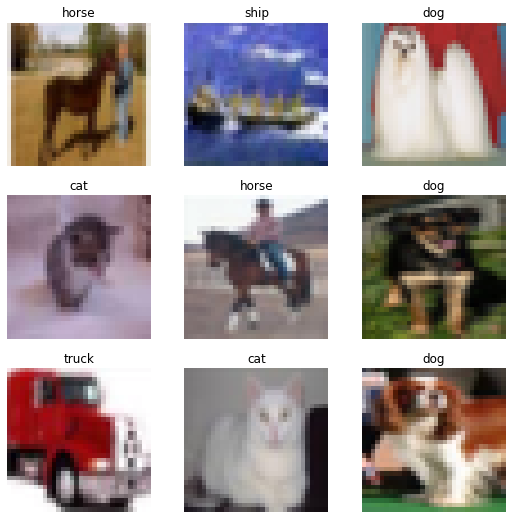

In [ ]:
dls.show_batch()

In [ ]:
learner = cnn_learner(dls, resnet18, metrics=accuracy, concat_pool=False)

start fit


SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.03981071710586548)

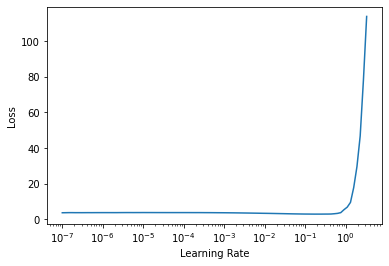

In [ ]:
learner.xla_lr_find(stop_div=False)

In [ ]:
learner.xla_fine_tune(3, freeze_epochs=3, base_lr=1.4e-1)

start fit


epoch,train_loss,valid_loss,accuracy,time
0,1.457094,1.360047,0.543800,00:28
1,1.233609,1.109528,0.641500,00:25
2,1.244920,1.214783,0.641900,00:25


start fit


epoch,train_loss,valid_loss,accuracy,time
0,0.787229,0.940910,0.742000,00:28
1,0.688949,0.620964,0.800600,00:27
2,0.434694,0.495070,0.837500,00:27


In [ ]:
learner.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
learner.unfreeze()

start fit


SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=4.786300905834651e-06)

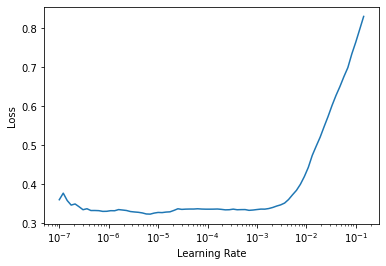

In [ ]:
learner.xla_lr_find()

In [ ]:
learner.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 16 x 16   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                      

In [ ]:
learner.xla_fit_one_cycle(5, lr_max=slice(2.2e-6, 2e-4))

start fit


epoch,train_loss,valid_loss,accuracy,time
0,0.279832,0.514679,0.831300,00:44
1,0.313973,0.535487,0.826300,00:27
2,0.312082,0.502534,0.838200,00:28
3,0.313781,0.526809,0.829100,00:28
4,0.309075,0.521618,0.830200,00:28


In [ ]:
learner.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 16 x 16   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                      